<a href="https://colab.research.google.com/github/Mona3087/pdf-rag/blob/main/pdf_rag_lcel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install -qU langchain langchain-core langchain-community langchain-openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 817.7/817.7 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.3/299.3 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.4/116.4 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.3/312.3 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.1/141.1 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.1 MB/s eta 0:00:00


In [3]:
!pip install -qU qdrant-client

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.3/229.3 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 5.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.14.0 requires protobuf<4.21,>=3.20.3, but you have protobuf 4.25.3 which is incompatible.


In [4]:
!pip install -qU tiktoken pymupdf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.8/30.8 MB 32.5 MB/s eta 0:00:00


In [5]:
import os
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")

OpenAI API Key:··········


In [6]:
from langchain_openai import ChatOpenAI

openai_chat_model = ChatOpenAI(model="gpt-3.5-turbo")

In [7]:
from langchain_openai.embeddings import OpenAIEmbeddings

embedding_model = OpenAIEmbeddings(model="text-embedding-3-small")

In [8]:
import tiktoken

enc = tiktoken.encoding_for_model("gpt-3.5-turbo")

In [9]:
from langchain.document_loaders import PyMuPDFLoader

docs = PyMuPDFLoader("https://d18rn0p25nwr6d.cloudfront.net/CIK-0001326801/c7318154-f6ae-4866-89fa-f0c589f2ee3d.pdf").load()

In [10]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

def tiktoken_len(text):
    tokens = tiktoken.encoding_for_model("gpt-3.5-turbo").encode(
        text,
    )
    return len(tokens)

In [11]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 200,
    chunk_overlap = 10,
    length_function = tiktoken_len,
)

split_chunks = text_splitter.split_documents(docs)

In [12]:
max_chunk_length = 0

for chunk in split_chunks:
  max_chunk_length = max(max_chunk_length, tiktoken_len(chunk.page_content))

print(max_chunk_length)

199


In [13]:
from langchain_community.vectorstores import Qdrant

qdrant_vectorstore = Qdrant.from_documents(
    split_chunks,
    embedding_model,
    location=":memory:",
    collection_name="Facebook 10k",
)

In [14]:
qdrant_retriever = qdrant_vectorstore.as_retriever()

In [15]:
from langchain_core.prompts import ChatPromptTemplate
RAG_PROMPT = """
CONTEXT:
{context}

QUERY:
{question}
Answer the question based on {context}, if you can't figure just say "I don't know"
"""

rag_prompt = ChatPromptTemplate.from_template(RAG_PROMPT)

In [16]:
from operator import itemgetter
from langchain.schema.output_parser import StrOutputParser
from langchain.schema.runnable import RunnablePassthrough

retrieval_augmented_qa_chain = (
    # INVOKE CHAIN WITH: {"question" : "<<SOME USER QUESTION>>"}
    # "question" : populated by getting the value of the "question" key
    # "context"  : populated by getting the value of the "question" key and chaining it into the base_retriever
    {"context": itemgetter("question") | qdrant_retriever, "question": itemgetter("question")}
    # "context"  : is assigned to a RunnablePassthrough object (will not be called or considered in the next step)
    #              by getting the value of the "context" key from the previous step
    | RunnablePassthrough.assign(context=itemgetter("context"))
    # "response" : the "context" and "question" values are used to format our prompt object and then piped
    #              into the LLM and stored in a key called "response"
    # "context"  : populated by getting the value of the "context" key from the previous step
    | {"response": rag_prompt | openai_chat_model, "context": itemgetter("context")}
)

In [17]:
response = retrieval_augmented_qa_chain.invoke({"question" : "What was the total value of 'Cash and cash equivalents' as of December 31, 2023?"})

In [18]:
response["response"].content

"The total value of 'Cash and cash equivalents' as of December 31, 2023, was $41,862 billion."

In [19]:
for context in response["context"]:
  print("Context:")
  print(context)
  print("----")

Context:
page_content='Table of Contents\n\xa0\n\xa0\nFair Value Measurement at Reporting Date Using\nDescription\nDecember 31, 2022\nQuoted\xa0Prices in Active\nMarkets for\nIdentical\xa0Assets\n(Level 1)\nSignificant Other\nObservable Inputs\n(Level 2)\nSignificant Unobservable\nInputs\n(Level 3)\nCash\n$\n6,176\xa0\nCash equivalents:\nMoney market funds\n8,305\xa0\n$\n8,305\xa0\n$\n—\xa0\n$\n—\xa0\nU.S. government and agency securities\n16\xa0\n16\xa0\n—\xa0\n—\xa0\nTime deposits\n156\xa0\n—\xa0\n156\xa0\n—\xa0\nCorporate debt securities\n28\xa0\n—\xa0\n28\xa0\n—\xa0\nTotal cash and cash equivalents\n14,681\xa0\n8,321\xa0\n184\xa0\n—\xa0\nMarketable securities:\nU.S. government securities\n8,708' metadata={'source': 'https://d18rn0p25nwr6d.cloudfront.net/CIK-0001326801/c7318154-f6ae-4866-89fa-f0c589f2ee3d.pdf', 'file_path': 'https://d18rn0p25nwr6d.cloudfront.net/CIK-0001326801/c7318154-f6ae-4866-89fa-f0c589f2ee3d.pdf', 'page': 108, 'total_pages': 147, 'format': 'PDF 1.4', 'title': '

In [20]:
response = retrieval_augmented_qa_chain.invoke({"question" : "Who are Meta's 'Directors' (i.e., members of the Board of Directors)?"})

In [21]:
response["response"].content

'The directors of Meta are:\n1. Aaron Anderson\n2. Peggy Alford\n3. Marc L. Andreessen\n4. Andrew W. Houston\n5. Nancy Killefer\n6. Robert M. Kimmitt\n7. Sheryl K. Sandberg\n8. Tracey T. Travis\n9. Tony Xu'

In [22]:
for context in response["context"]:
  print("Context:")
  print(context)
  print("----")

Context:
page_content="(I.R.S. Employer Identification Number)\n1 Meta Way, Menlo Park, California 94025\n(Address of principal executive offices and Zip Code)\n(650)\xa0543-4800\n(Registrant's telephone number, including area code)\n__________________________\nSecurities registered pursuant to Section 12(b) of the Act:\nTitle of each class\nTrading symbol(s)\nName of each exchange on which registered\nClass A Common Stock, $0.000006 par value\nMETA\nThe Nasdaq Stock Market LLC\nSecurities registered pursuant to Section 12(g) of the Act: None\nIndicate by check mark if the registrant is a well-known seasoned issuer, as defined in Rule 405 of the Securities Act.\xa0\xa0\xa0\xa0Yes\xa0\xa0☒\xa0\xa0No\xa0\xa0 ☐" metadata={'source': 'https://d18rn0p25nwr6d.cloudfront.net/CIK-0001326801/c7318154-f6ae-4866-89fa-f0c589f2ee3d.pdf', 'file_path': 'https://d18rn0p25nwr6d.cloudfront.net/CIK-0001326801/c7318154-f6ae-4866-89fa-f0c589f2ee3d.pdf', 'page': 0, 'total_pages': 147, 'format': 'PDF 1.4', 't

In [23]:
response = retrieval_augmented_qa_chain.invoke({"question" : "What is temperature of the Sun?"})

In [24]:
response["response"].content

"I don't know"

In [25]:
!pip install -qU ragas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.1/71.1 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 13.9 MB/s eta 0:00:00


In [26]:
loader = PyMuPDFLoader(
    "https://d18rn0p25nwr6d.cloudfront.net/CIK-0001326801/c7318154-f6ae-4866-89fa-f0c589f2ee3d.pdf",
)

eval_documents = loader.load()

text_splitter_eval = RecursiveCharacterTextSplitter(
    chunk_size = 600,
    chunk_overlap = 50
)

eval_documents = text_splitter_eval.split_documents(eval_documents)

In [28]:
from ragas.testset.generator import TestsetGenerator
from ragas.testset.evolutions import simple, reasoning, multi_context
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

generator_llm = ChatOpenAI(model="gpt-4-turbo")
# critic_llm = ChatOpenAI(model="gpt-3.5-turbo") <--- If you don't have GPT-4 access, or run into rate-limit, or `nan` issues.
critic_llm = ChatOpenAI(model="gpt-4-turbo")
embeddings = OpenAIEmbeddings()

generator = TestsetGenerator.from_langchain(
    generator_llm,
    critic_llm,
    embeddings
)

distributions = {
    simple: 0.5,
    multi_context: 0.4,
    reasoning: 0.1
}

testset = generator.generate_with_langchain_docs(eval_documents, 5, distributions, is_async = False)
testset.to_pandas()

embedding nodes:   0%|          | 0/2202 [00:00<?, ?it/s]

Generating:   0%|          | 0/5 [00:00<?, ?it/s]

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



,question,contexts,ground_truth,evolution_type,metadata,episode_done
0,What is the role of accumulated other comprehe...,[losses are recorded in accumulated other comp...,Accumulated other comprehensive income (loss) ...,simple,[{'source': 'https://d18rn0p25nwr6d.cloudfront...,True
1,What are the potential business impacts of fai...,"[in our business operations, as a result of Eu...",The potential business impacts of failing to c...,simple,[{'source': 'https://d18rn0p25nwr6d.cloudfront...,True
2,How are assets allocated to different stock cl...,[Right to Receive Liquidation Distributions\nU...,"Upon the dissolution, liquidation, or winding-...",multi_context,[{'source': 'https://d18rn0p25nwr6d.cloudfront...,True
3,How do RSUs affect diluted EPS under an Equity...,"[the calculation of diluted EPS, net income fo...",RSUs (Restricted Stock Units) affect diluted E...,reasoning,[{'source': 'https://d18rn0p25nwr6d.cloudfront...,True


In [29]:
test_df = testset.to_pandas()

In [30]:
test_df

,question,contexts,ground_truth,evolution_type,metadata,episode_done
0,What is the role of accumulated other comprehe...,[losses are recorded in accumulated other comp...,Accumulated other comprehensive income (loss) ...,simple,[{'source': 'https://d18rn0p25nwr6d.cloudfront...,True
1,What are the potential business impacts of fai...,"[in our business operations, as a result of Eu...",The potential business impacts of failing to c...,simple,[{'source': 'https://d18rn0p25nwr6d.cloudfront...,True
2,How are assets allocated to different stock cl...,[Right to Receive Liquidation Distributions\nU...,"Upon the dissolution, liquidation, or winding-...",multi_context,[{'source': 'https://d18rn0p25nwr6d.cloudfront...,True
3,How do RSUs affect diluted EPS under an Equity...,"[the calculation of diluted EPS, net income fo...",RSUs (Restricted Stock Units) affect diluted E...,reasoning,[{'source': 'https://d18rn0p25nwr6d.cloudfront...,True


In [31]:
test_questions = test_df["question"].values.tolist()
test_groundtruths = test_df["ground_truth"].values.tolist()

In [32]:
answers = []
contexts = []

for question in test_questions:
  response = retrieval_augmented_qa_chain.invoke({"question" : question})
  answers.append(response["response"].content)
  contexts.append([context.page_content for context in response["context"]])

In [33]:
from datasets import Dataset

response_dataset = Dataset.from_dict({
    "question" : test_questions,
    "answer" : answers,
    "contexts" : contexts,
    "ground_truth" : test_groundtruths
})

In [34]:
from ragas import evaluate
from ragas.metrics import (
    faithfulness,
    answer_relevancy,
    answer_correctness,
    context_recall,
    context_precision,
)

metrics = [
    faithfulness,
    answer_relevancy,
    context_recall,
    context_precision,
    answer_correctness,
]

In [35]:
results = evaluate(response_dataset, metrics)

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

In [36]:
results

{'faithfulness': 1.0000, 'answer_relevancy': 0.9741, 'context_recall': 1.0000, 'context_precision': 0.9792, 'answer_correctness': 0.6391}

In [37]:
results_df = results.to_pandas()
results_df

,question,answer,contexts,ground_truth,faithfulness,answer_relevancy,context_recall,context_precision,answer_correctness
0,What is the role of accumulated other comprehe...,The role of accumulated other comprehensive in...,[recognized as a charge in interest and other ...,Accumulated other comprehensive income (loss) ...,1.0,1.000000,1.0,0.916667,0.742018
1,What are the potential business impacts of fai...,Failing to comply with GDPR and the ePrivacy D...,[Table of Contents\ntwo prior adequacy framewo...,The potential business impacts of failing to c...,1.0,0.981584,1.0,1.000000,0.235456
2,How are assets allocated to different stock cl...,"When a company dissolves, the assets legally a...",[Right to Receive Liquidation Distributions\nU...,"Upon the dissolution, liquidation, or winding-...",1.0,0.914756,1.0,1.000000,0.743916
3,How do RSUs affect diluted EPS under an Equity...,RSUs affect diluted EPS under an Equity Incent...,"[stock, while the diluted EPS of Class B commo...",RSUs (Restricted Stock Units) affect diluted E...,1.0,1.000000,1.0,1.000000,0.835118


In [38]:
from langchain.retrievers import MultiQueryRetriever
advanced_retriever = MultiQueryRetriever.from_llm(retriever=qdrant_retriever, llm=openai_chat_model)

In [46]:
!pip install langchainhub

In [47]:
from langchain import hub

retrieval_qa_prompt = hub.pull("langchain-ai/retrieval-qa-chat")

In [48]:
from langchain.chains.combine_documents import create_stuff_documents_chain

document_chain = create_stuff_documents_chain(openai_chat_model, retrieval_qa_prompt)

In [49]:
from langchain.chains import create_retrieval_chain

retrieval_chain = create_retrieval_chain(advanced_retriever, document_chain)

In [50]:
response = retrieval_chain.invoke({"input": "Who are Meta's 'Directors' (i.e., members of the Board of Directors)?"})

In [51]:
answers = []
contexts = []

for question in test_questions:
  response = retrieval_chain.invoke({"input" : question})
  answers.append(response["answer"])
  contexts.append([context.page_content for context in response["context"]])

In [52]:
response_dataset_advanced_retrieval = Dataset.from_dict({
    "question" : test_questions,
    "answer" : answers,
    "contexts" : contexts,
    "ground_truth" : test_groundtruths
})

In [53]:
advanced_retrieval_results = evaluate(response_dataset_advanced_retrieval, metrics)

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

In [54]:
advanced_retrieval_results_df = advanced_retrieval_results.to_pandas()
advanced_retrieval_results_df

,question,answer,contexts,ground_truth,faithfulness,answer_relevancy,context_recall,context_precision,answer_correctness
0,What is the role of accumulated other comprehe...,Accumulated other comprehensive income (loss) ...,[recognized as a charge in interest and other ...,Accumulated other comprehensive income (loss) ...,1.0,0.872606,1.0,1.00,0.841798
1,What are the potential business impacts of fai...,The potential business impacts of failing to c...,"[Table of Contents\nOrders issued by, or inqui...",The potential business impacts of failing to c...,1.0,1.000000,1.0,1.00,0.239308
2,How are assets allocated to different stock cl...,"Upon dissolution, liquidation, or winding-up o...",[Right to Receive Liquidation Distributions\nU...,"Upon the dissolution, liquidation, or winding-...",1.0,0.890507,1.0,0.95,0.847605
3,How do RSUs affect diluted EPS under an Equity...,RSUs (Restricted Stock Units) can affect dilut...,"[stock, while the diluted EPS of Class B commo...",RSUs (Restricted Stock Units) affect diluted E...,1.0,0.964651,1.0,1.00,0.616642


In [55]:
import pandas as pd

df_original = pd.DataFrame(list(results.items()), columns=['Metric', 'Baseline'])
df_comparison = pd.DataFrame(list(advanced_retrieval_results.items()), columns=['Metric', 'MultiQueryRetriever with Document Stuffing'])

df_merged = pd.merge(df_original, df_comparison, on='Metric')

df_merged['Delta'] = df_merged['MultiQueryRetriever with Document Stuffing'] - df_merged['Baseline']

df_merged

,Metric,Baseline,MultiQueryRetriever with Document Stuffing,Delta
0,faithfulness,1.000000,1.000000,0.000000
1,answer_relevancy,0.974085,0.931941,-0.042144
2,context_recall,1.000000,1.000000,0.000000
3,context_precision,0.979167,0.987500,0.008333
4,answer_correctness,0.639127,0.636338,-0.002789


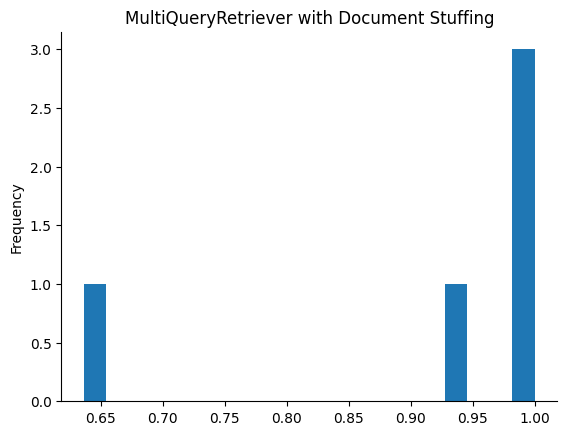

In [56]:
# @title MultiQueryRetriever with Document Stuffing

from matplotlib import pyplot as plt
df_merged['MultiQueryRetriever with Document Stuffing'].plot(kind='hist', bins=20, title='MultiQueryRetriever with Document Stuffing')
plt.gca().spines[['top', 'right',]].set_visible(False)